In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt
import pickle

# custom classes for cross validation and scoring
import cross_validation
import performance_metrics

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv(r"../data/processed_data/complete_data.csv", index_col=0)


In [3]:
# split into features
x = data.drop(["TARGET"], axis=1)
y = data.filter(["TARGET"], axis=1)
y = y.values.reshape(y.shape[0])

# split dataset for hyperparameter tuning and kfold
split = 0.5
hp_x, hp_y = x[:int(len(x) * split)], y[:int(len(y) * split)] # hyperparameter set
kf_x, kf_y = x[int(len(x) * split):], y[int(len(y) * split):] # kfold set

hp_x.shape, hp_y.shape, kf_x.shape, kf_y.shape


((282686, 202), (282686,), (282686, 202), (282686,))

In [4]:
# scale the data for hyperparameter tuning
scaler = StandardScaler()
hp_x = scaler.fit_transform(hp_x)

In [5]:
def model_builder(hp):
    model = LogisticRegression(
        C=hp.Float("c", 1e-3, 1e+2),
        penalty="l2",
        solver=hp.Choice("solver", ["liblinear", "saga", "lbfgs", "sag"]),
        max_iter=10000
    )
    
    return model

In [7]:
project_name = "lr_v2"

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective("score", "max"),
        max_trials=20
    ),
    hypermodel=model_builder,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=KFold(2, shuffle=True, random_state=7243),
    directory=f"../logs/lr/{project_name}",
    project_name=project_name
)

In [8]:
tuner.search(hp_x, hp_y)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
23.326            |23.326            |c
saga              |saga              |solver



In [ ]:
# save the model architecture 
hpModel = tuner.get_best_models(1)[0]

with open(f"logistic_regression/{project_name}.pkl", "wb") as file:
    pickle.dump(hpModel, file)

In [ ]:
# load the model    
with open(f"logistic_regression/{project_name}.pkl", "rb") as file:
    loaded_model = pickle.load(file)

kfold = KFold(n_splits=5, shuffle=True, random_state=663)

# run cross validation for the model
cv = cross_validation.cross_val(kf_x, kf_y)
results, confusion_matrix = cv.run_validation(kfold=kfold, model=loaded_model, scaler=scaler)

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed
Validation Completed


In [ ]:
# save to csv for easy viewing
results.to_csv(f"../results/logistic_regression/scores-{project_name}.csv")

results.round(4) * 100

,accuracy,precision,recall,f1,auc,fpr,fnr
Model,,,,,,,
1,95.45,99.45,91.43,95.27,95.46,0.25,4.29
2,95.45,99.43,91.53,95.32,95.50,0.27,4.28
3,95.54,99.29,91.68,95.33,95.51,0.33,4.14
4,95.53,99.47,91.59,95.37,95.55,0.25,4.23
5,95.55,99.43,91.59,95.35,95.53,0.26,4.19
Average,95.50,99.41,91.56,95.33,95.51,0.27,4.23


In [ ]:
# save confusion matrix 
cm_df = pd.DataFrame(confusion_matrix)
cm_df.to_csv(f"../results/logistic_regression/cmdata-{project_name}.csv")

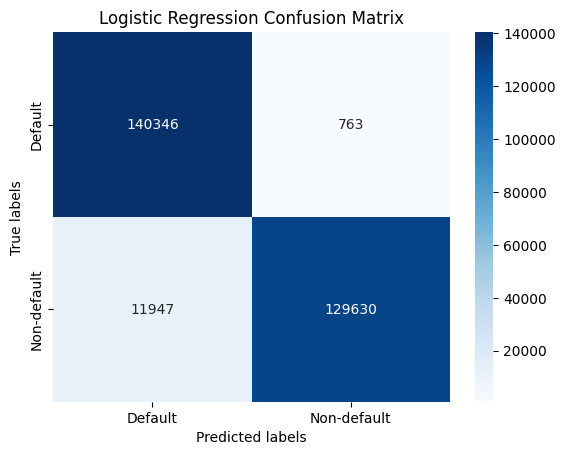

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

# Set labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression Confusion Matrix')

tick_labels = ['Default', 'Non-default']
tick_positions = [0, 1]
plt.xticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)
plt.yticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)

# Show the plot
plt.show()

plt.tight_layout()

graph = fig.get_figure()
graph.savefig(f"../results/logistic_regression/cm-{project_name}.png")

In [ ]:
np.array(kf_x.shape).reshape(1, -1)

array([[282686,    202]])

In [ ]:
x.shape

(282686, 202)

In [ ]:
x.shape

(282686, 202)

In [ ]:
x = scaler.transform(kf_x)
y = kf_y

interpretation_model = loaded_model.fit(x, y)

with open(f"logistic_regression/{project_name}-interpretation.pkl", "wb") as file:
    pickle.dump(interpretation_model, file)